In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
import tensorflow as tf #tf 2.0.0
import splitfolders

In [2]:
#Creamos los directorios de entrenamiento testeo y validación
classes=['french_bulldog','german_shepherd','golden_retriever','poodle']
dataset_dir='dogs'
#Se opta por dividir el dataset en 80% entrenamiento, 10% testeo y 10% validación
splitfolders.ratio(dataset_dir, output="output", seed=1337, ratio=(0.8, 0.1,0.1), group_prefix=None) # default values


Copying files: 80 files [00:00, 179.79 files/s]


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Preprocesamiento de las imagenes para obtener mas variabilidad de las pocas fotos que tenemos
train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
#A las imagenes de desteo no se las aumenta, solo se las escala numericamente para ser conciso con el resto de las imagenes
test_data_gen = ImageDataGenerator(rescale=1./255)

In [14]:
#Parametros del modelo con el que vamos a trabajar
Batch_size = 8
img_h = 256
img_w = 256

In [6]:
#Por temas de reproducibilidad se fija la semilla
SEED = 1234
tf.random.set_seed(SEED) 
#Se crean los directorios de entrenamitno, testeo y validación 
training_dir = os.path.join('output', 'train')
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(256, 256),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)  
# Validation
valid_dir = os.path.join('output', 'val')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(256, 256),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='categorical',
                                           shuffle=False,
                                           seed=SEED)
# Test
test_dir = os.path.join('output', 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             target_size=(256, 256),
                                             batch_size=10, 
                                             shuffle=False,
                                             seed=SEED,
                                             class_mode=None,
                                             )

Found 64 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


In [13]:


#Importamos el  modelo ResNet152V2 y realizamos transfer training, a su vez agregamos capas densa par ala clasificación final y dropout para evitar overfitting
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
     

from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

#Se fijan los pesos de imagenet y se congelan las capas de la red a excepecion de las que agregamos nosotros para finetuneear el modelo
for layer in ResNet_model.layers[:-5]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=4, activation='softmax')(x)
model = Model(ResNet_model.input, output)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [16]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'],run_eagerly=True)

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)


callbacks = [lrr]

In [18]:

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

transfer_learning_history = model.fit(train_gen,
                   steps_per_epoch=STEP_SIZE_TRAIN,
                   validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID,
                   epochs=10,
                  callbacks=callbacks,verbose=1
                  
                    
)


Epoch 1/10
64/64 [==============================] - 143s 2s/step - loss: 0.9427 - accuracy: 0.6406 - val_loss: 1.3722 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/10
64/64 [==============================] - 149s 2s/step - loss: 0.6049 - accuracy: 0.7344 - val_loss: 1.3414 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/10
64/64 [==============================] - 143s 2s/step - loss: 0.5327 - accuracy: 0.8281 - val_loss: 1.5776 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
64/64 [==============================] - 133s 2s/step - loss: 0.2009 - accuracy: 0.9531 - val_loss: 1.2524 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 5/10
64/64 [==============================] - 140s 2s/step - loss: 0.4190 - accuracy: 0.8906 - val_loss: 0.6079 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/10
64/64 [==============================] - 139s 2s/step - loss: 0.4912 - accuracy: 0.8594 - val_loss: 1.7725 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/10
64/64 [==============================] - 144s 2s/step - loss: 0.2

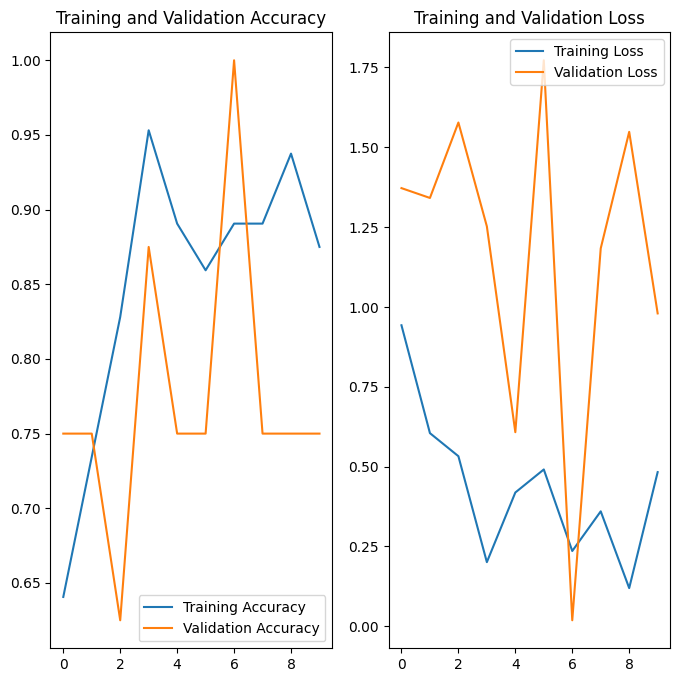

In [19]:
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model.evaluate(valid_gen, steps=STEP_SIZE_VALID,verbose=1)


8/8 [==============================] - 5s 623ms/step - loss: 0.1613 - accuracy: 1.0000


[0.16128142178058624, 1.0]

In [21]:
pred = model.predict(test_gen,
                     steps=1,
                     verbose=1)

     

1/1 [==============================] - 3s 3s/step
